In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import scipy.io.wavfile as wf
from peek import peek

from pydub import AudioSegment
from pydub.playback import play

import librosa.display

In [3]:
filepath = "music/the_story_so_far/The Story So Far 'Clairvoyant'-y7FauV3MIUU.mp3"

In [4]:
sound_stereo = AudioSegment.from_file(filepath, format='mp3')
sound_L = sound_stereo.split_to_mono()[0]
sound_R = sound_stereo.split_to_mono()[1]

sound_R_inv = sound_R.invert_phase()
sound_L_inv = sound_L.invert_phase()

In [13]:
sound_mid = sound_L + sound_R
sound_side = sound_L - sound_R
sound_side_inv = sound_side.invert_phase()
sound_vocals = sound_mid - sound_side_inv

TypeError: AudioSegment objects can't be subtracted from each other

In [8]:
dir(sound_R)
sound_R[0]

In [ ]:
y, sr = librosa.load(filepath)

In [ ]:
rate, data = wf.read('clairvoyant.wav')
# data0 is the data from channel 0.
print(data.shape)
data_l = data[:, 0]
data_r = data[:, 1]

In [ ]:
S_full, phase = librosa.magphase(librosa.stft(y))

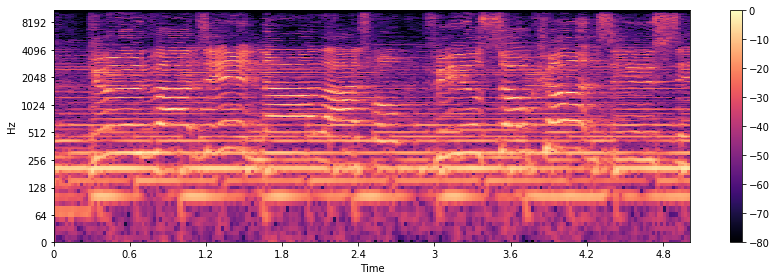

In [7]:
idx = slice(*librosa.time_to_frames([30,35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [8]:
S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr)))
S_filter = np.minimum(S_full, S_filter)

In [9]:
margin_i, margin_v = 2, 10
power = 2
mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)
S_foreground = mask_v * S_full
S_background = mask_i * S_full

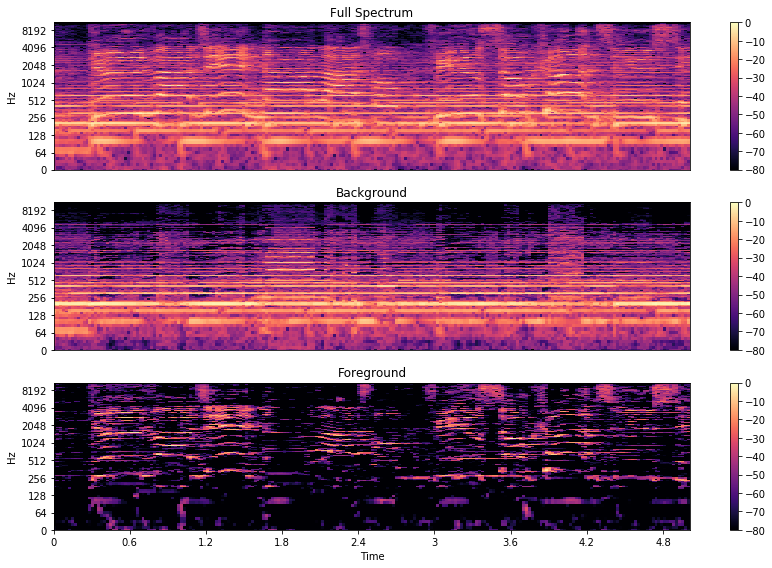

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', sr=sr)
plt.title('Full Spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max), y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [22]:
D_foreground = 4 * S_foreground # * phase

# librosa.output.write_wav('output.wav', librosa.istft(D_foreground), sr)
sf.write('output_D.wav', librosa.istft(D_foreground), sr, subtype='PCM_24')
